In [168]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, set_seed, GPT2Tokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split
import re
import nltk
import torch.nn as nn
from nltk.corpus import stopwords
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [169]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'intents.json'

intents = load_json_file(filename)

In [170]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [171]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [172]:
df.shape

(405, 2)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [174]:
df.isnull().sum()

Pattern    0
Tag        0
dtype: int64

In [175]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

C:\Users\yatch\AppData\Local\Temp\ipykernel_26724\1755447801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


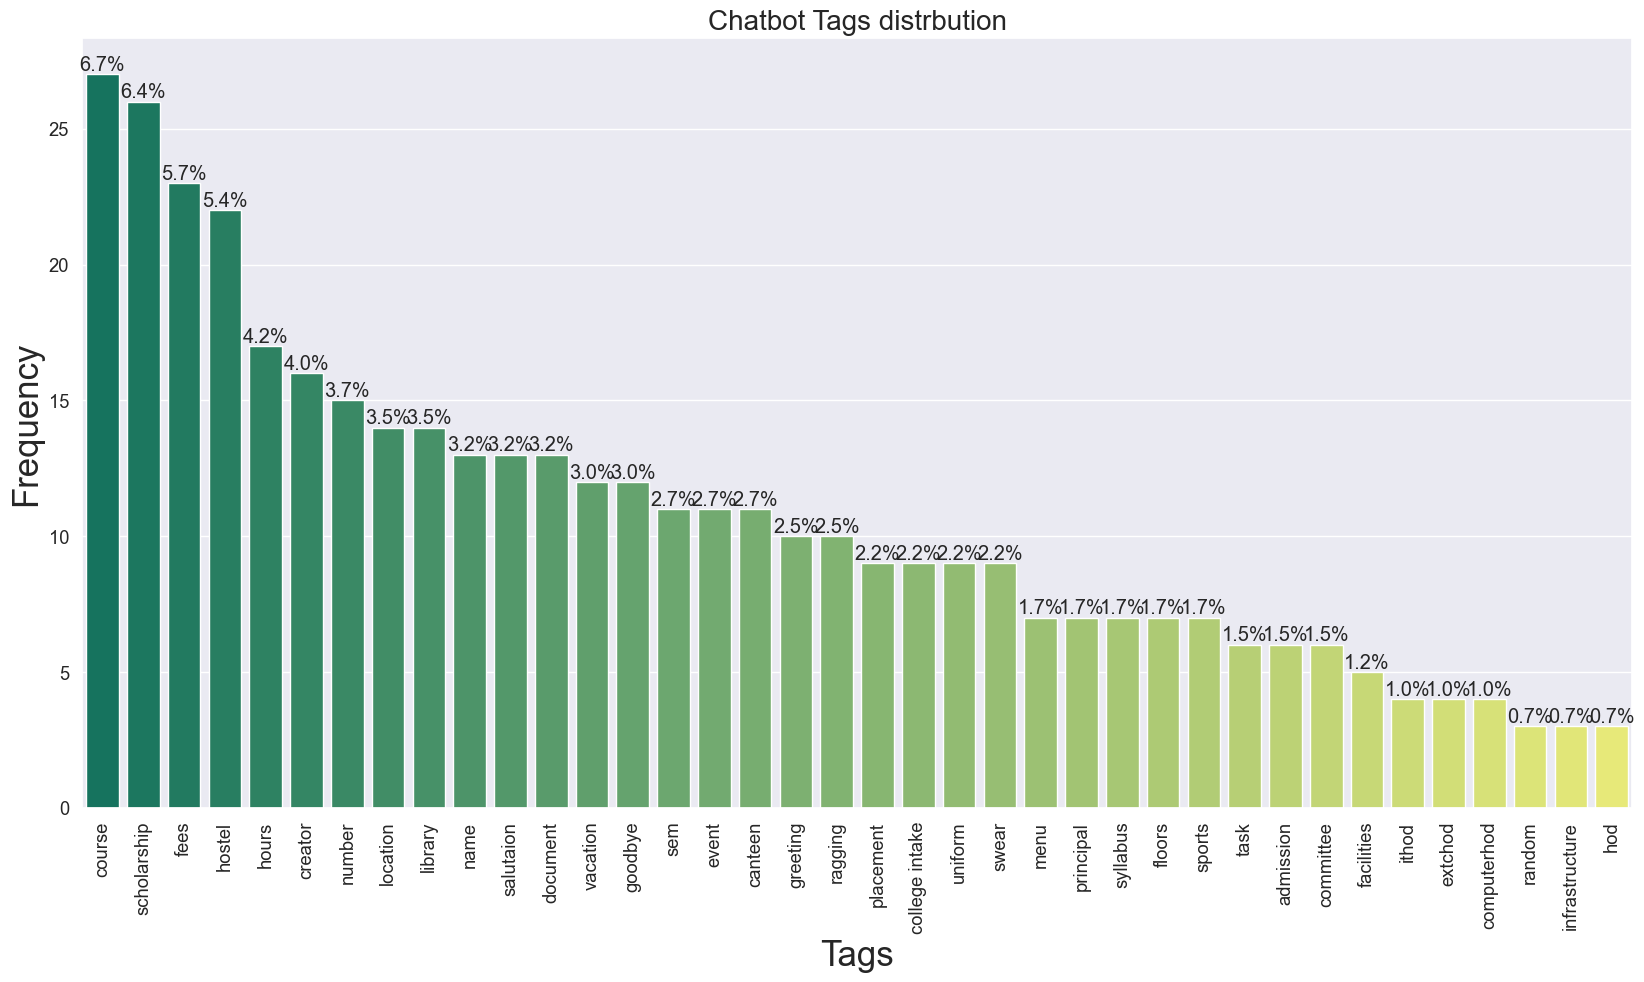

In [176]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

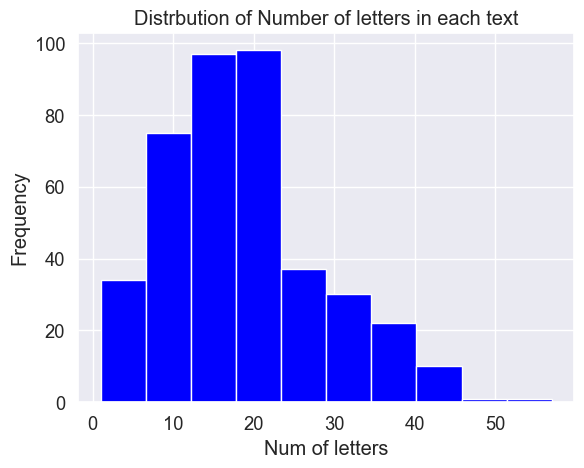

In [177]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='blue')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

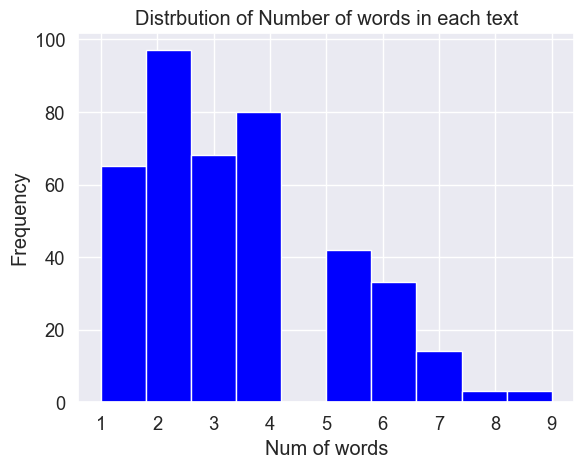

In [178]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='blue')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

C:\Users\yatch\AppData\Local\Temp\ipykernel_26724\3841709485.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


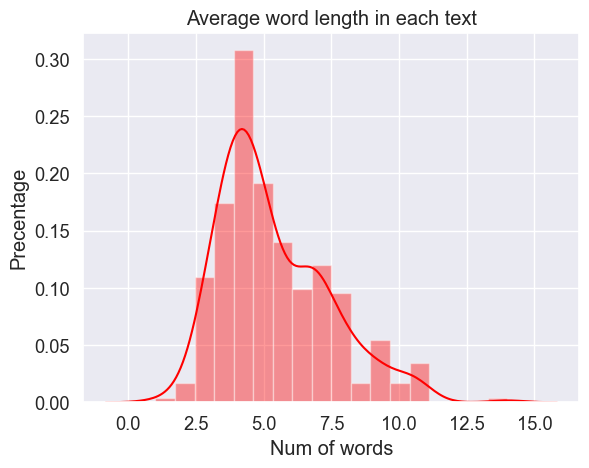

In [179]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [180]:
labels = df['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [181]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [182]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [183]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [184]:
df['labels'] = df['Tag'].map(lambda x: label2id[x.strip()])
df.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


In [185]:
X = list(df['Pattern'])
y = list(df['labels'])
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

In [186]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Model
class CustomGPT2Model(nn.Module):
    def __init__(self, model_name="gpt2", num_labels=2):
        super(CustomGPT2Model, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained(model_name)
        self.lstm = nn.LSTM(input_size=self.gpt2.config.hidden_size, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(64, num_labels)
        self.id2lable = id2label
        self.label2id = label2id

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        lstm_output, _ = self.lstm(outputs.last_hidden_state)
        print(lstm_output.shape)
        dropout_output = self.dropout(lstm_output[:, -1, :])
        logits = self.classifier(dropout_output)
        return logits

# Initialize the tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

model = CustomGPT2Model(model_name, 
                        num_labels=num_labels)


In [187]:
# Set the tokenizer's pad token
tokenizer.pad_token = tokenizer.eos_token

# Now encode your datasets
train_encoding = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
test_encoding = tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")

In [188]:
full_data = tokenizer(X, truncation=True, padding=True)

In [189]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [190]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [191]:
fullDataLoader = DataLoader(full_data, y_test)

In [192]:
# Define an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define a loss function
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [193]:
# Training loop
model.train()  # Set the model to training mode
for epoch in range(epochs):  # epochs is the number of training epochs
    for batch in train_dataloader:
        # Assuming your DataLoader yields batches as dictionaries
        # with 'input_ids' and 'attention_mask' for input data,
        # and 'labels' for labels
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(**inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

torch.Size([16, 64])


C:\Users\yatch\AppData\Local\Temp\ipykernel_26724\3425902195.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


IndexError: too many indices for tensor of dimension 2